In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import _pickle as pkl
from copy import deepcopy
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
from IPython.core.debugger import set_trace

In [4]:
# classification accuracy plotting
def plot_test_acc(plot_handles):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel("Test Accuracy")
    plt.ylim(0,1)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
def shuffle_aligned_list(data):
    """Shuffle arrays in a list by shuffling each array identically."""
    num = data[0].shape[0]
    p = np.random.permutation(num)
    return [d[p] for d in data]    
    
def batch_generator(data, batch_size, shuffle=True):
    """Generate batches of data.
    
    Given a list of array-like objects, generate batches of a given
    size by yielding a list of array-like objects corresponding to the
    same slice of each input.
    """
    if shuffle:
        data = shuffle_aligned_list(data)

    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size >= len(data[0]):
            batch_count = 0

            if shuffle:
                data = shuffle_aligned_list(data)

        start = batch_count * batch_size
        end = start + batch_size
        batch_count += 1
        yield [d[start:end] for d in data]    
    
# train/compare vanilla sgd and ewc
def train_task(model, num_iter, disp_freq, trainset_imgs, trainset_labels, testsets_imgs, testsets_labels, x, y_, lams=[0]):
    # Batch generators
    train_batch = batch_generator([trainset_imgs, trainset_labels], 100)
    
    for l in range(len(lams)):
        # lams[l] sets weight on old task(s)
        model.restore(sess) # reassign optimal weights from previous training session
        if(lams[l] == 0):
            model.set_vanilla_loss()
        else:
            model.update_ewc_loss(lams[l])
        # initialize test accuracy array for each task 
        test_accs = []
        for task in range(len(testsets_imgs)):
            test_accs.append(np.zeros(int(num_iter/disp_freq)))
        # train on current task
        for iter in range(num_iter):
            #batch = trainset.train.next_batch(100)
            #model.train_step.run(feed_dict={x: batch[0], y_: batch[1]})
            
            X, y = train_batch.__next__()
            model.train_step.run(feed_dict={x: X, y_: y})
            if iter % disp_freq == 0:
                plt.subplot(1, len(lams), l+1)
                plots = []
                colors = ['r', 'b', 'g']
                for task in range(len(testsets_imgs)):
                    #feed_dict={x: testsets[task].test.images, y_: testsets[task].test.labels}
                    feed_dict={x: testsets_imgs[task], y_: testsets_labels[task]}
                    
                    test_accs[task][int(iter/disp_freq)] = model.accuracy.eval(feed_dict=feed_dict)
                    c = chr(ord('A') + task)
                    plot_h, = plt.plot(range(1,iter+2,disp_freq), test_accs[task][:int(iter/disp_freq)+1], colors[task], label="task " + c)
                    plots.append(plot_h)
                plot_test_acc(plots)
                if l == 0: 
                    plt.title("vanilla sgd")
                else:
                    plt.title("ewc")
                plt.gcf().set_size_inches(len(lams)*5, 3.5)

In [5]:
# Load MNIST-M
mnistm = input_data.read_data_sets('MNIST_data', one_hot=True)
mnistm_imgs = pkl.load(open('/data/public-dataset/MNIST_M/mnistm_data.pkl', 'rb'), encoding='latin1')

print("Training", mnistm_imgs['train'].shape, mnistm.train.labels.shape)
print("Test", mnistm_imgs['test'].shape, mnistm.test.labels.shape)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Training (55000, 28, 28, 3) (55000, 10)
Test (10000, 28, 28, 3) (10000, 10)


In [6]:
sess = tf.InteractiveSession()

In [7]:
# define input and target placeholders
x = tf.placeholder(tf.uint8, [None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [9]:
# import class Model
from mnistm_model import Model

# instantiate new model
model = Model(x, y_) # simple 2-layer network

# initialize variables
sess.run(tf.global_variables_initializer())

train on task MNIST-M, test on task MNIST-M

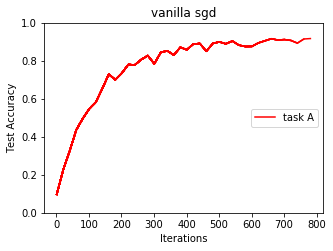

In [10]:
# training 1st task
train_task(model, 800, 20, mnistm_imgs['train'], mnistm.train.labels, 
                           [mnistm_imgs['test']], [mnistm.test.labels], x, y_, lams=[0])

In [6]:
# Load SVHN
from scipy.io import loadmat

def to_categorical(y, nb_classes=None):
    """ to_categorical.
    Convert class vector (integers from 0 to nb_classes)
    to binary class matrix, for use with categorical_crossentropy.
    Arguments:
        y: `array`. Class vector to convert.
        nb_classes: `unused`. Used for older code compatibility.
    """
    return (y[:, None] == np.unique(y)).astype(np.float32)

def load_data(path):
    """ Helper function for loading a MAT-File"""
    data = loadmat(path)
    
    for i in range(len(data['y'])):
        if data['y'][i]%10 == 0:
            data['y'][i] = 0
    data['y'] = to_categorical(data['y'],10)
    
    return data['X'], data['y']

svhn_images = {}
svhn_labels = {}

svhn_images['train'], svhn_labels['train']  = load_data('/data/public-dataset/SVHN/train_32x32.mat')
svhn_images['test'], svhn_labels['test']  = load_data('/data/public-dataset/SVHN/test_32x32.mat')

sess = tf.InteractiveSession()

# image resizing
svhn_images['train']=svhn_images['train'].transpose(3, 0, 1, 2)
svhn_images['test']=svhn_images['test'].transpose(3, 0, 1, 2)

svhn_images['train']=tf.image.resize_images(svhn_images['train'], [28, 28], method=1).eval()
svhn_images['test']=tf.image.resize_images(svhn_images['test'], [28, 28], method=1).eval()


svhn_labels['train'] = svhn_labels['train'].reshape(73257, 10)
svhn_labels['test'] = svhn_labels['test'].reshape(26032, 10)

print("Training", svhn_images['train'].shape, svhn_labels['train'].shape)
print("Test", svhn_images['test'].shape, svhn_labels['test'].shape)

Training (73257, 28, 28, 3) (73257, 10)
Test (26032, 28, 28, 3) (26032, 10)


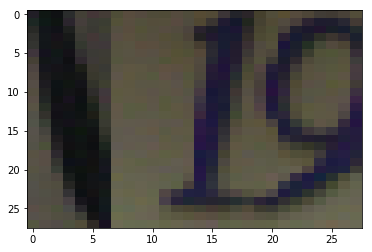

In [7]:
plt.imshow(svhn_images['train'][0],aspect="auto")

In [8]:
sess = tf.InteractiveSession()

In [9]:
# define input and target placeholders
x = tf.placeholder(tf.uint8, [None, 28, 28, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [10]:
# import class Model
from mnistm_model import Model

# instantiate new model
model2 = Model(x, y_) # simple 2-layer network

# initialize variables
sess.run(tf.global_variables_initializer())

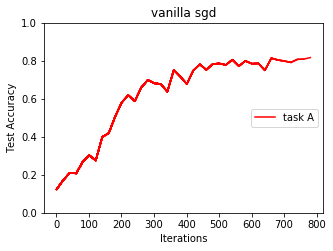

In [11]:
# training 1st task
train_task(model2, 800, 20, svhn_images['train'], svhn_labels['train'], 
                           [svhn_images['test']], [svhn_labels['test']], x, y_, lams=[0])

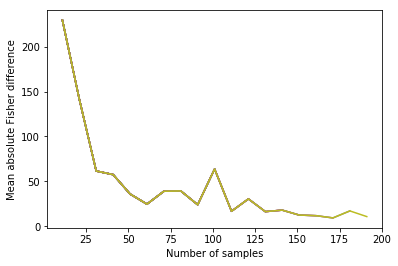

In [12]:
# Fisher information
model2.compute_fisher(svhn_images['test'], sess, num_samples=200, plot_diffs=True) # use validation set for Fisher computation

In [13]:
# save current optimal weights
model2.star()

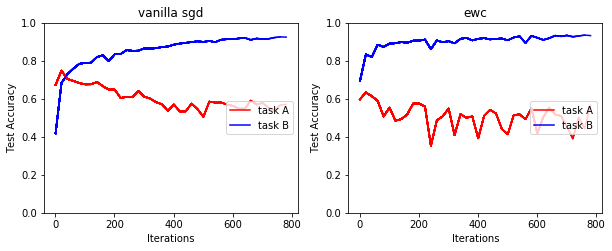

In [14]:
# training 2nd task
train_task(model2, 800, 20, mnistm_imgs['train'], mnistm.train.labels, 
                           [svhn_images['test'], mnistm_imgs['test']], [svhn_labels['test'], mnistm.test.labels], x, y_, lams=[0, 15])